PART 1 

In [31]:
# Importing Libraries 
import cv2
import numpy as np 
from matplotlib import pyplot as plt
import pickle
import os

In [32]:
# Functions 

def get_images(img_dir_path):
    images = []
    for i in range(64):
        image = cv2.imread(os.path.join(img_dir_path,'image_%03d.png'%(i)))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = gray.astype(np.float32) / 255.0
        images.append(gray)

    return images 

def get_light_directions(light_dirs_path): 
   # Load lighting direction vectors
    light_dirs = pickle.load( open( light_dirs_path, "rb" ) )
    return light_dirs


"""
find_height_map: returns [192x168] numpy array of heights

surface_normals: _________ numpy array of surface normal vectors
"""

def find_height_map(surface_normals, integration_method):
   
   sn_x = surface_normals[:,:,0]
   sn_y = surface_normals[:,:,1]
   sn_z = surface_normals[:,:,2]

   # Computing partial derivatives REMOVE NEGATIVE
   # delta_x = -sn_x/sn_z
   # delta_y = -sn_y/sn_z

   epsilon = 1e-5
   valid = np.abs(sn_z) > epsilon

   # Initialize with zeros
   delta_x = np.zeros_like(sn_z)
   delta_y = np.zeros_like(sn_z)

   #Only divide where sn_z is large enough
   delta_x[valid] = sn_x[valid] / sn_z[valid]
   delta_y[valid] = sn_y[valid] / sn_z[valid]


   # Initialise height_map
   row, col = sn_x.shape
   height_map_row = np.zeros((row, col)) 
   height_map_col = np.zeros((row, col)) 
   height_map_avg = np.zeros((row, col)) 

   # ------ROW-WISE--------------------------------------------
   # Cumulative sum over first row 
   height_map_row[0,:] = np.cumsum(delta_x[0,:])

   # Summing down each column 
   for i in range(1, row): 
      height_map_row[i, :] = height_map_row[i-1, :] + delta_y[i, :]

   
   # ------COL-WISE--------------------------------------------
   # Cumulative sum down first column 
   height_map_col[:,0] = np.cumsum(delta_y[:,0])

   # Summing across each row
   for i in range(1, col): 
      height_map_col[:, i] = height_map_col[:, i-1] + delta_x[:, i]


   # ------AVERAGE---------------------------------------------
   height_map_avg = (height_map_row+height_map_col)/2
   

   if integration_method == "row wise":
      return height_map_row
   
   elif integration_method == "column wise": 
      return height_map_col
   
   elif integration_method == "average": 
      return height_map_avg

   return None



def find_albedo_normals(images, light_directions):
    
    # Collate all the pixel data for each pixel from each light source 
    images = np.stack(images, axis=2)  
    print(images.shape)

    # Image dimesnions
    height, width, num_images = images.shape
   
    # Calculating albedo and normals 
    albedo = np.zeros((height, width))
    normals = np.zeros((height, width, 3))

    for h in range(height): 
        for w in range(width): 
            intensities = images[h, w, :]
            g_xy, _, _, _ = np.linalg.lstsq(light_directions, intensities, rcond = None)
            albedo[h,w] = np.linalg.norm(g_xy)      # magnitude of g_xy
            normals[h,w,:] = g_xy/albedo[h,w]       # direction of g_xy

    return albedo, normals





"""
plot_face_3d: produces textured 3D mesh of face data

height_map: [192x168] numpy array of heights
albedo: [192x168] numpy array of albedos (between 0-1)

Note: x-axis displayed in figure is flipped for better viewing
"""
def plot_face_3d(height_map, albedo):

    h, w = albedo.shape[:2]

    X, Y = np.meshgrid(np.arange(w, 0, -1), np.arange(0, h))
    fc = np.empty([h, w, 3])
    fc[:,:,0] = albedo
    fc[:,:,1] = albedo
    fc[:,:,2] = albedo

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, height_map, facecolors=fc, rstride=1, cstride=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
   #  ax.axis('equal')
   #  ax.axis('auto')

    plt.show()


In [33]:
# Reading in Datasets 

# Path to images and light direction data 
img01_dir_path = 'yale_face_data/image_dir_B01'
light01_dirs_path = 'yale_face_data/light_dirB01.pkl'
img02_dir_path = 'yale_face_data/image_dir_B02'
light02_dirs_path = 'yale_face_data/light_dirB02.pkl'
img05_dir_path = 'yale_face_data/image_dir_B05'
light05_dirs_path = 'yale_face_data/light_dirB05.pkl'
img07_dir_path = 'yale_face_data/image_dir_B07'
light07_dirs_path = 'yale_face_data/light_dirB07.pkl'


# Extract images and light direction data 
images_01 = get_images(img01_dir_path)
light_directions_01 = get_light_directions(light01_dirs_path)
images_02 = get_images(img02_dir_path)
light_directions_02 = get_light_directions(light02_dirs_path)
images_05 = get_images(img05_dir_path)
light_directions_05 = get_light_directions(light05_dirs_path)
images_07 = get_images(img07_dir_path)
light_directions_07 = get_light_directions(light07_dirs_path)


# Extract albedo and surface normals data 
B01_data_path = 'yale_face_data/B01_albedo_normals.pkl'
data = pickle.load( open( B01_data_path, "rb" ) )
albedo_01 = data['albedo_image']
surface_normals_01 = data['surface_normals']

albedo_02, surface_normals_02 = find_albedo_normals(images_02, light_directions_02)
albedo_05, surface_normals_05 = find_albedo_normals(images_05, light_directions_05)
albedo_07, surface_normals_07 = find_albedo_normals(images_07, light_directions_07)



(192, 168, 64)
(192, 168, 64)
(192, 168, 64)


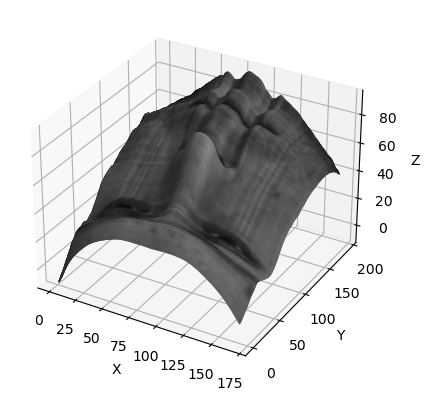

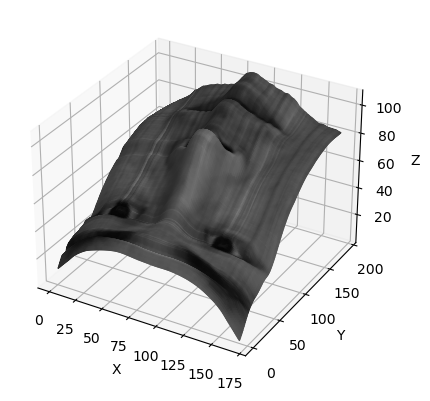

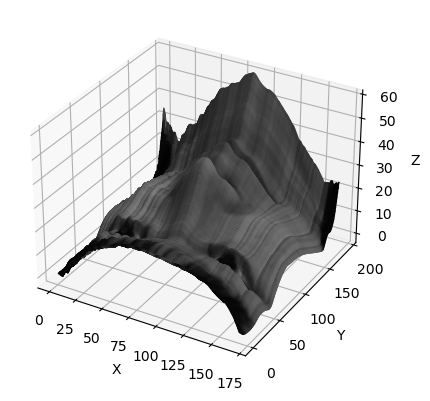

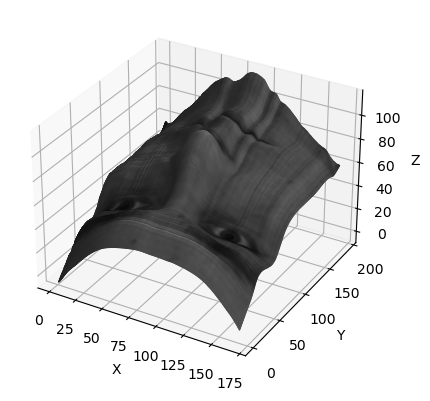

In [34]:
# Producing 3D plots of all faces 

integration_method = "average"

height_map_01 = find_height_map(surface_normals_01, integration_method)
height_map_02 = find_height_map(surface_normals_02, integration_method)
height_map_05 = find_height_map(surface_normals_05, integration_method)
height_map_07 = find_height_map(surface_normals_07, integration_method)

plot_face_3d(height_map_01, albedo_01)
plot_face_3d(height_map_02, albedo_02)
plot_face_3d(height_map_05, albedo_05)
plot_face_3d(height_map_07, albedo_07)

PART 2 - Reducing Noise

In [42]:
# Functions for computing residuals 

def compute_residuals(images, albedo, light_directions, surface_normals): 

   # Re-format images 
   images = np.stack(images, axis=2) 
   height, width, num_images = images.shape 

   residuals = np.zeros((height, width, num_images))
   
   for i in range(num_images): 
      I_rendered = albedo*(np.dot(surface_normals, light_directions[i]))
      I_rendered = np.clip(I_rendered,0, 255)

      residuals[:,:,i] = abs(images[:,:,i] - I_rendered)

      # dot_product = np.sum(surface_normals * light_directions[i], axis=2)

      # # Rendered image under this light: I = ρ * (n · l)
      # I_rendered = albedo * dot_product
      # I_rendered = np.clip(I_rendered, 0, 1)  # Clamp to [0, 1]

      # Compute residuals
      residuals[:, :, i] = images[:, :, i] - I_rendered

   return residuals 


def plot_residual_magnitude(residuals): 
   
   height, width, num_images = residuals.shape

   # residuals = np.abs(residuals)

   residual_mask = np.zeros((height, width, num_images))

   std_devs = np.std(residuals, axis=2)


   for i in range(num_images):
      residual_mask[:, :, i] = np.abs(residuals[:, :, i]) > (2 * std_devs[:,:])

    
   fig, axes = plt.subplots(8, 8, figsize=(12, 12))
   for i, ax in enumerate(axes.flat):
      ax.imshow(residual_mask[:,:,i], cmap='gray')
      ax.set_title(f'{i}')
      ax.axis('off')
   plt.suptitle("Pixels with Residuals Greater than 2x Standard Deviation")
   plt.tight_layout()
  
   return None



def find_albedo_normals_residuals(images, light_directions, residual_mask):
  
    # Image dimesnions
    images = np.stack(images, axis=2) 
    height, width, num_images = images.shape 
   
    # Calculating albedo and normals 
    albedo = np.zeros((height, width))
    normals = np.zeros((height, width, 3))

   
    for h in range(height): 
        for w in range(width):
            valid_images = []
            for i in range(num_images): 
               if (residual_mask[h,w,i] == 0): 
                  valid_images.append(i)
            # valid_images = np.where(residual_mask[h, w, :] == 0)[0]
            # print(valid_images)
            # if np.sum(valid_images) < 3:
            #     continue  
            
            intensities = images[h, w, valid_images]
            light_dirs = light_directions[valid_images]

            g_xy, _, _, _ = np.linalg.lstsq(light_dirs, intensities, rcond = None)
            norm = np.linalg.norm(g_xy)    

            if norm > 0: 
               albedo[h,w] = norm 
               normals[h,w,:] = g_xy/albedo[h,w]     
            
    return albedo, normals







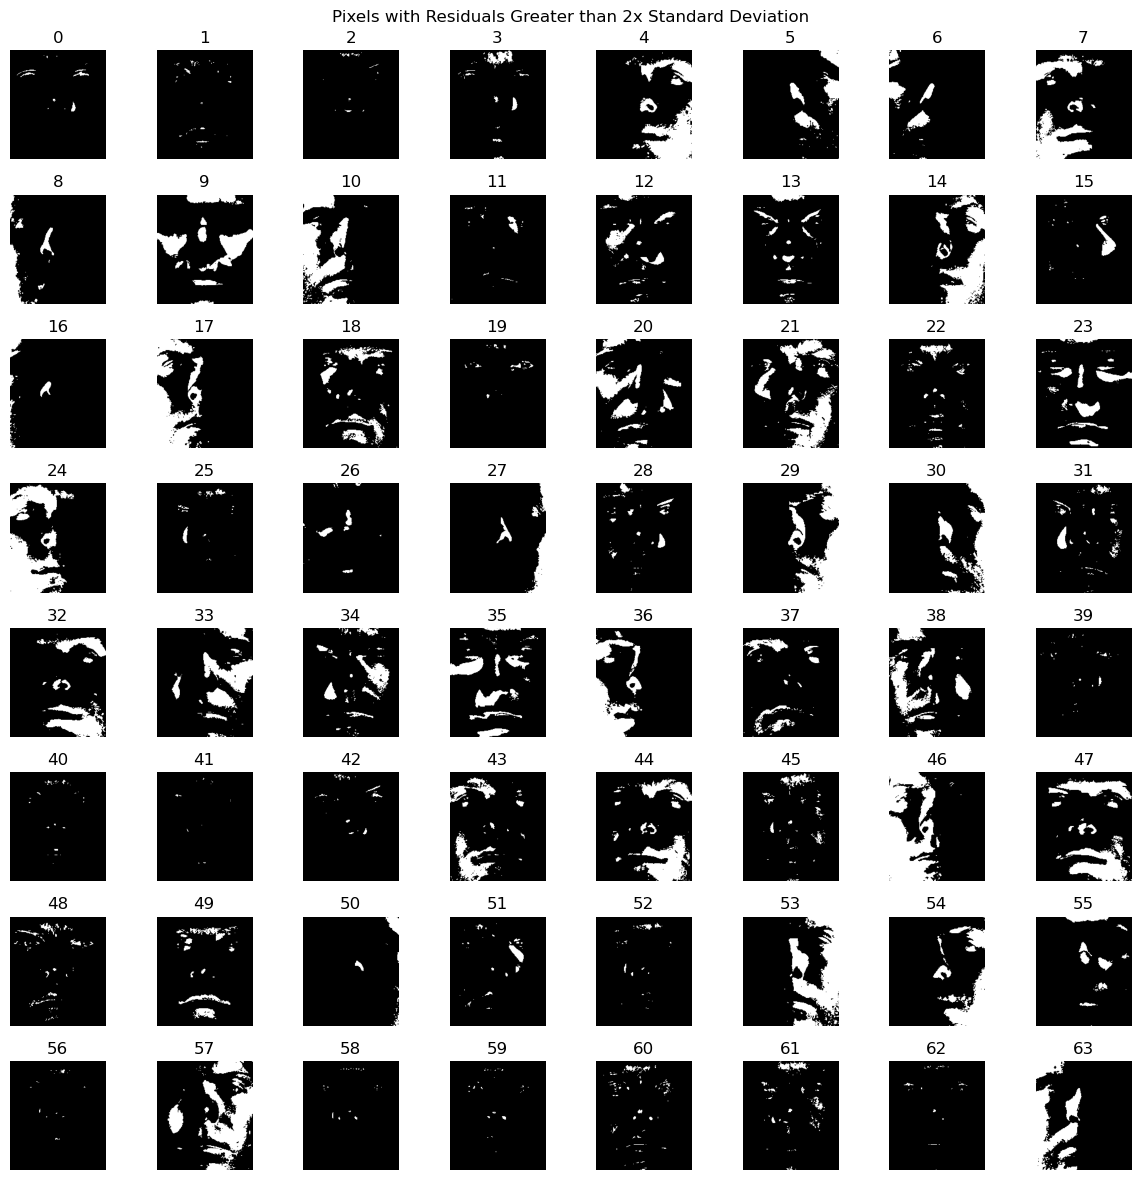

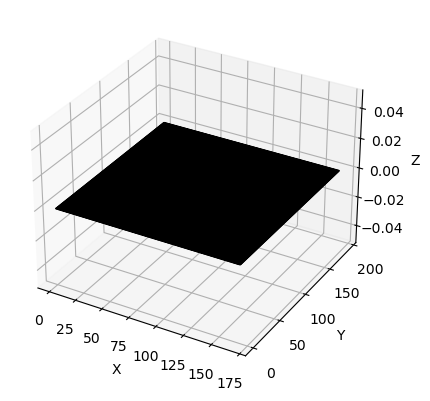

In [43]:

residuals_01 = compute_residuals(images_01, albedo_01, light_directions_01, surface_normals_01)

plot_residual_magnitude(residuals_01)


albedo_residuals_01, normal_residuals_01 = find_albedo_normals_residuals(images_01, light_directions_01, residuals_01)
height_map_residuals_01 = find_height_map(normal_residuals_01, integration_method)
plot_face_3d(height_map_residuals_01, albedo_residuals_01)


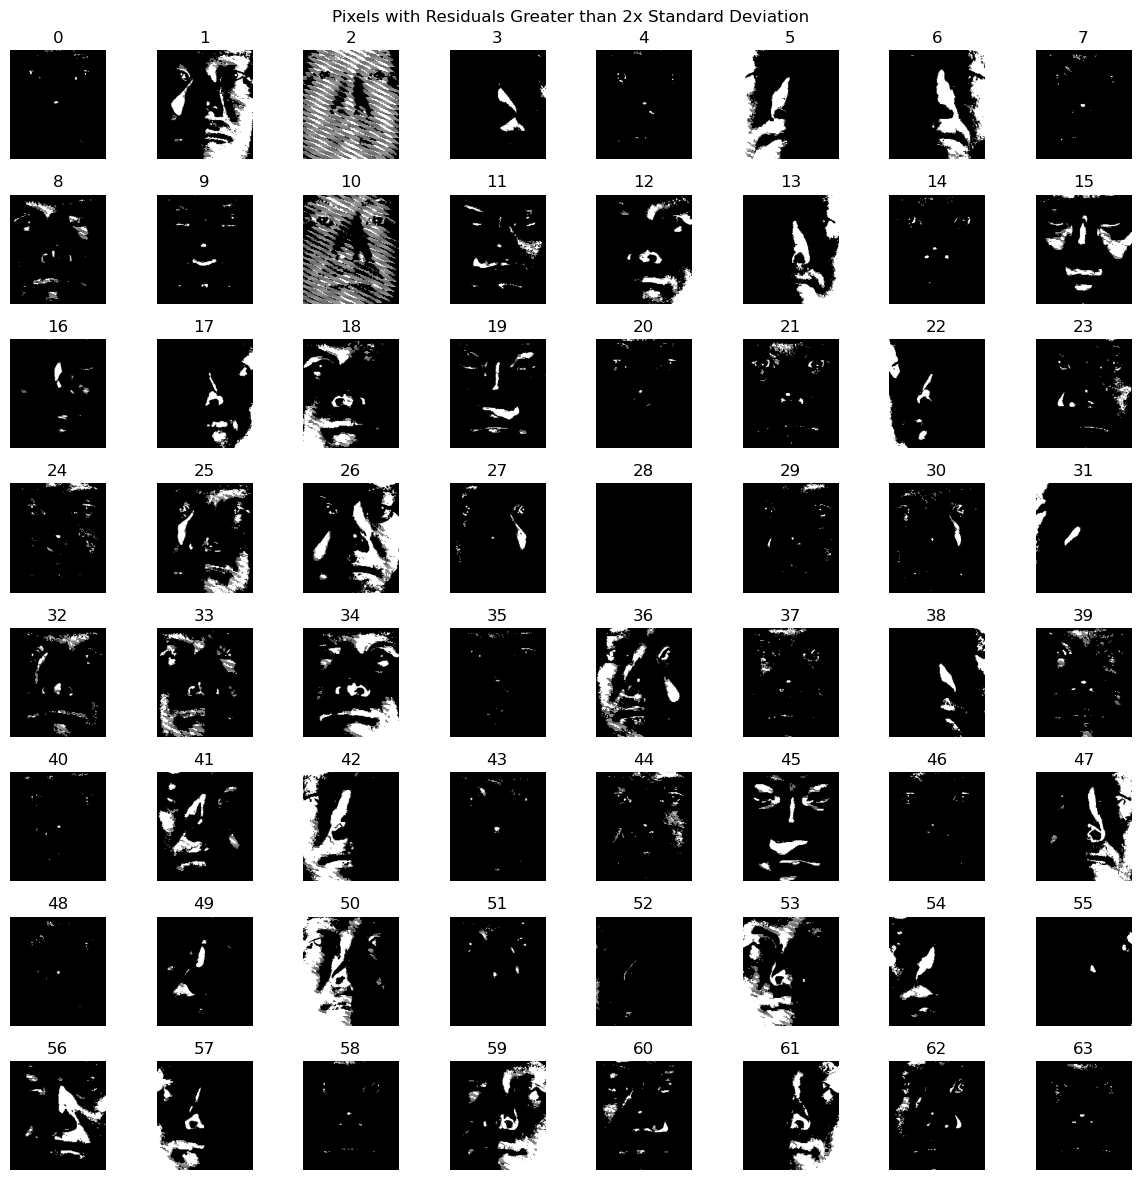

In [37]:
residuals_02 = compute_residuals(images_02, albedo_02, light_directions_02, surface_normals_02)

plot_residual_magnitude(residuals_02)

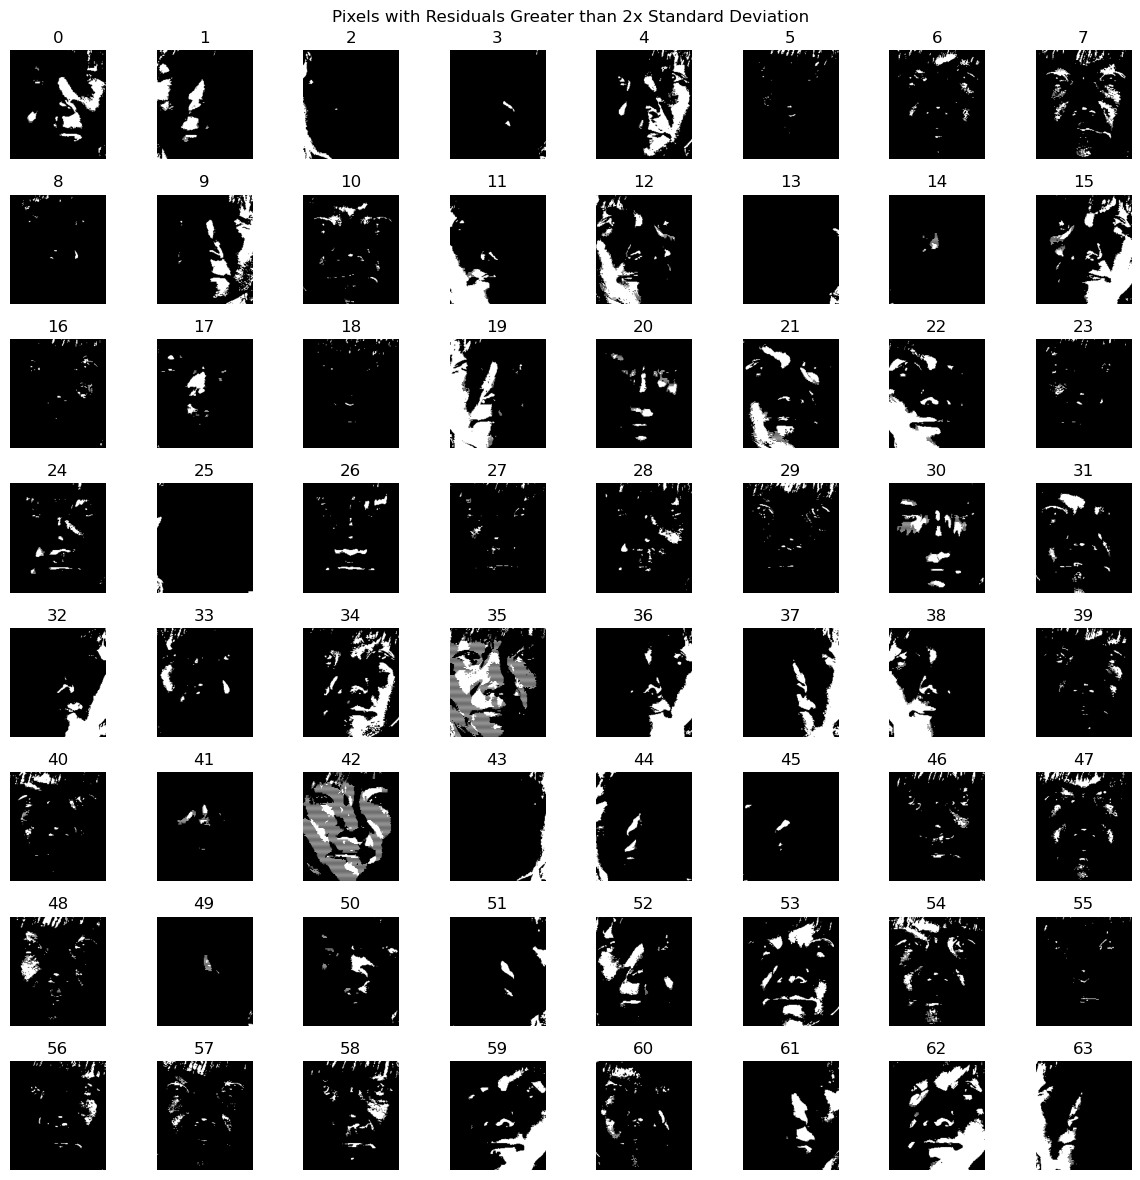

In [38]:
residuals_05 = compute_residuals(images_05, albedo_05, light_directions_05, surface_normals_05)

plot_residual_magnitude(residuals_05)

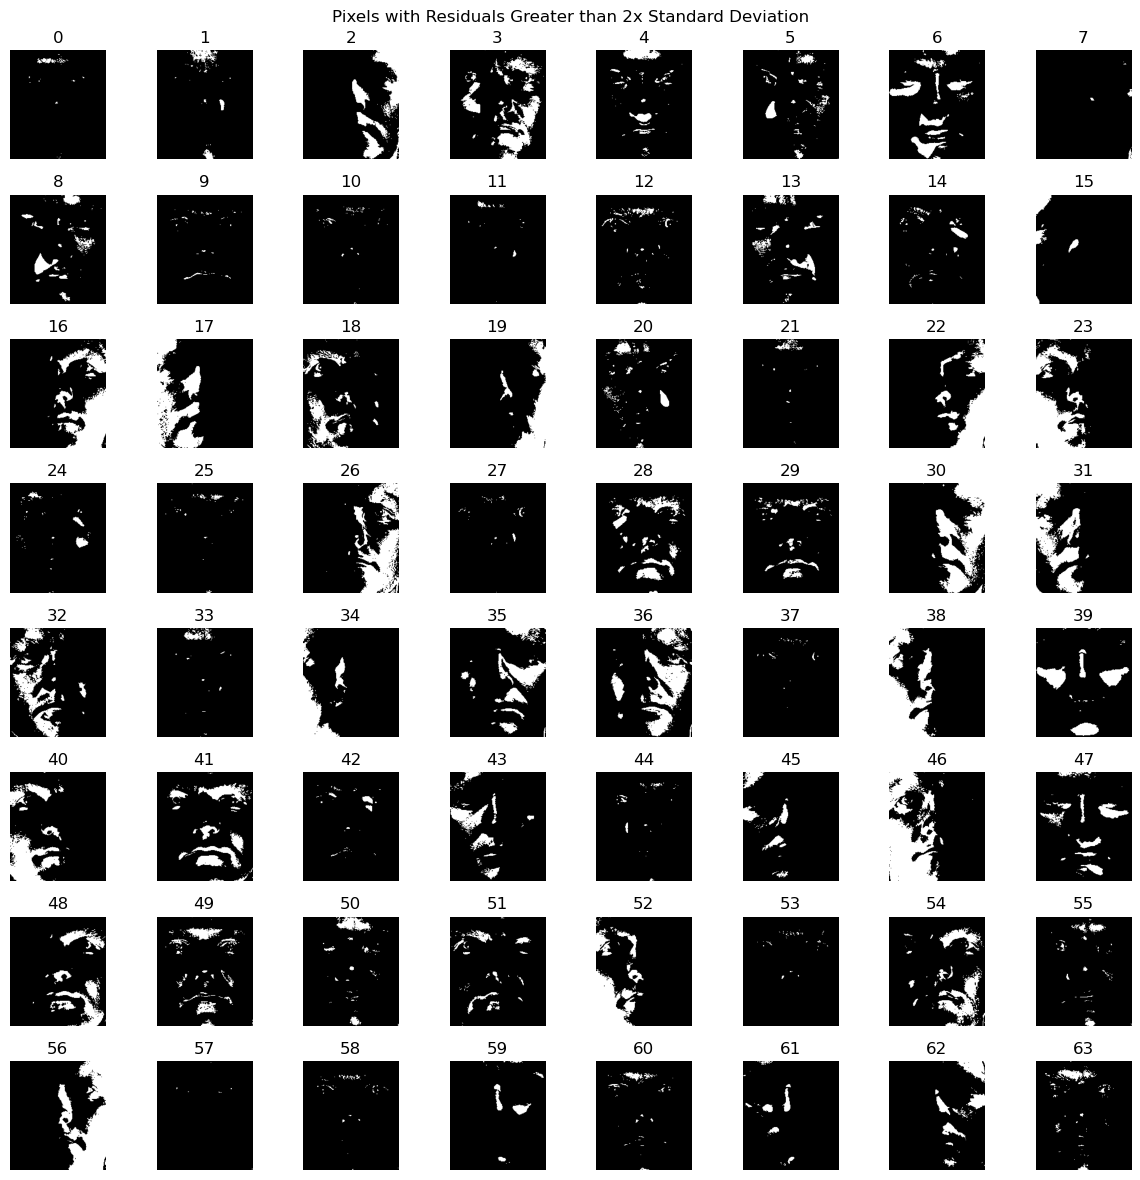

In [39]:
residuals_07 = compute_residuals(images_07, albedo_07, light_directions_07, surface_normals_07)

plot_residual_magnitude(residuals_07)